In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Reading animelist.csv

In [78]:
import os

In [79]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [80]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True,usecols=["user_id", "anime_id", "rating"])

In [81]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [82]:
len(rating_df)

5000000

### DATA PROCESSING

In [83]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [84]:
len(rating_df)

3246641

In [85]:
minimun_rating = min(rating_df["rating"])

In [86]:
maximun_rating = max(rating_df["rating"])

In [87]:
avg_rating = np.mean(rating_df["rating"])

In [88]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-minimun_rating)/(maximun_rating-minimun_rating)).values.astype(np.float64)

In [89]:
rating_df.duplicated().sum()

np.int64(0)

In [90]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [91]:
user_ids = rating_df["user_id"].unique().tolist()
user_encoding = {x: i for i , x in enumerate(user_ids)}
user_decoding = {i: x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user_encoding)

In [92]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [93]:
n_users = len(user_encoding)

In [94]:
n_users

4203

In [95]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime_encoding = {x: i for i , x in enumerate(anime_ids)}
anime_decoding = {i: x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime_encoding)

In [96]:
rating_df.tail()

,user_id,anime_id,rating,user,anime
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154
4999920,16507,308,0.0,4202,6584


In [97]:
n_anime = len(anime_encoding)

In [98]:
n_anime

17149

In [99]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [100]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [101]:
test_size = 1000
train_indicies = rating_df.shape[0]-test_size

In [102]:
X_train, X_test, y_train, y_test = (
    X[:train_indicies],
    X[train_indicies :],
    y[:train_indicies],
    y[train_indicies :]
)

In [103]:
X_train_array = [X_train[: , 0], X_train[:, 1]]
X_test_array = [X_test[: , 0], X_test[:, 1]]

### MODEL ARCHITECTURE

In [104]:
def RecomenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=['mae', 'mse'], optimizer='Adam')

    return model

In [105]:
model = RecomenderNet()

In [106]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [107]:
start_learn = 0.00001
min_learn = 0.00001
max_learn = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def learn_func (epoch):
    if epoch < ramup_epochs:
        return (max_learn-start_learn)/ramup_epochs*epoch + start_learn
    elif epoch < ramup_epochs+sustain_epochs:
        return max_learn
    else:
        return (max_learn-min_learn)*exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_learn

In [108]:
learn_callback = LearningRateScheduler(lambda epoch: learn_func(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [109]:
my_callbacks = [model_checkpoint, learn_callback, early_stopping]

In [110]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.8030 - mae: 0.3825 - mse: 0.1981 - val_loss: 0.7375 - val_mae: 0.3662 - val_mse: 0.1750 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.7994 - mae: 0.3812 - mse: 0.1967 - val_loss: 0.7746 - val_mae: 0.3731 - val_mse: 0.1882 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.7934 - mae: 0.3790 - mse: 0.1943 - val_loss: 0.7744 - val_mae: 0.3728 - val_mse: 0.1879 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.7848 - mae: 0.3756 - mse: 0.1909 - val_loss: 0.7701 - val_mae: 0.3714 - val_mse: 0.1862 - learning_rate: 3.4000e-05


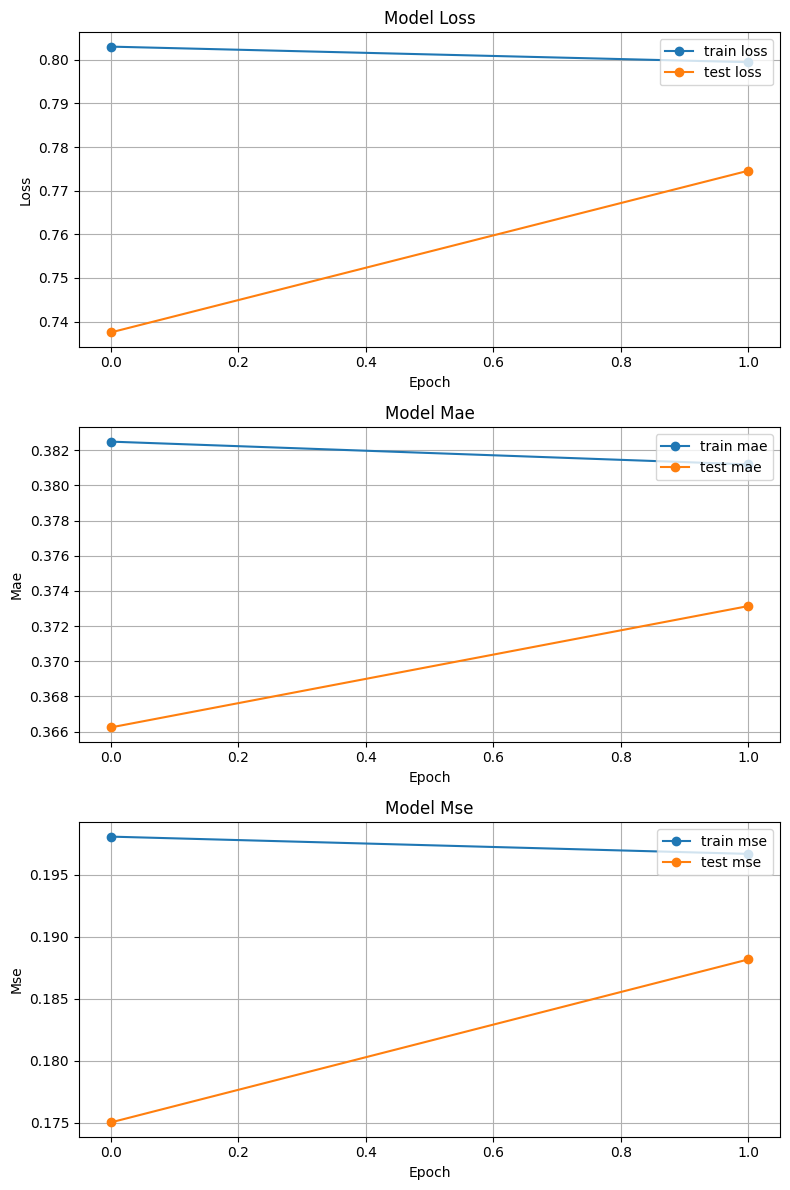

In [111]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2],marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [112]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [113]:
anime_weights = extract_weights("anime_embedding", model)

In [114]:
user_weights = extract_weights("user_embedding", model)

#### Reading anime.csv

In [115]:
df = pd.read_csv(INPUT_DIR+"/anime.csv")
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [116]:
df = df.replace("Unknown", np.nan)

In [117]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [118]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [119]:
getAnimeName(6702)

'Fairy Tail'

In [120]:
df.sort_values(by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last")

In [121]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [122]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [123]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [124]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [125]:
def getAnimeFrame (anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [126]:
getAnimeFrame(6702,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4707,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Shounen",175,TV,Fall 2009,1312470


In [127]:
getAnimeFrame("Naruto", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen",220,TV,Fall 2002,1830540


#### Reading anime_with_synopsis.csv

In [128]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [129]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [130]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [131]:
# def getSynopsis(anime,synopsis_df):
#     if isinstance(anime, int):
#         return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
#     if isinstance(anime, str):
#         return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

def getSynopsis(anime, df):
    if isinstance(anime, int):
        row = df[df.MAL_ID == anime]
    elif isinstance(anime, str):
        row = df[df.Name == anime]
    else:
        return "Invalid anime identifier"

    if row.empty:
        return "No synopsis available"
    
    return row['sypnopsis'].values[0]


In [132]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [133]:
getSynopsis("Steins;Gate", synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

#### Content based recomendation system 

In [134]:
pd.set_option("max_colwidth", None)

In [135]:
import traceback

In [136]:
def find_similar_animes(name,anime_weights,anime_encoding,anime_decoding,df,synopsis_df, 
                        n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime_encoding.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")
        
        weights = anime_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        for x in closest:
            decoded_id = anime_decoding.get(x)
            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[x]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis" : synopsis
            })
        
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        Frame = Frame[Frame.anime_id != index]
        return Frame.drop(["anime_id"],axis=1)

    except:
        print("error occured")

In [137]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime_encoding,
    anime_decoding,
    df,
    synopsis_df,
    n=10
)

,name,similarity,genre,synopsis
9,Maji,0.331600,"Drama, Shounen","aji is a young hood in the Nagisa criminal organization whose name is synonymous with loyalty and truth. While driving away thugs, he meets and falls for local high school girl, Kumiko; however, complications ensue when he and his group run into the rival Kikuchi gang looking for trouble. Based on the first four volumes of the gang chivalry manga by Ayumi Tachihara. (Source: ANN)"
8,Mind Game,0.328415,"Adventure, Comedy, Dementia, Psychological, Romance","fter seeing her jump onto a subway at the last second and getting her ankle crushed between the doors, Nishi reconnects with his high school sweetheart, Myon. Nishi is still very much in love with Myon, but is shocked to learn that she is engaged to another man. Nishi agrees to meet Myon's fiancé at her family's Yakitori restaurant, but members of the Yakuza storm the joint and murder Nishi when he tries to stop them from raping Myon. Nishi, now dead, wakes up and meets a constantly shapeshifting god, who mocks him for dying. The god tells Nishi to walk into a portal and disappear from existence, which Nishi rejects, choosing instead to sprint past the god and reanimate. With a new outlook on life and knowledge of how the Yakuza are going to attack him, Nishi kills one of the Yakuza with his own gun, fleeing in a stolen car with Myon and her sister. Acclaimed director Masaaki Yuasa's debut film, Mind Game 's constantly shifting visuals tell a story about living one's life without regrets that is unlike any other."
7,1000-nen Joou: Queen Millennia,0.324893,"Adventure, Fantasy, Drama, Sci-Fi","D 1999, the Earth was in a critical situation; a planet Lar Metal was approaching to the Earth. Meanwhile, Yukino Yayoi was heard about Lar Metal from Dr. Amamori of Tokyo Observatory. She was a junior high school teacher, but she also worked for Dr. Amamori who appreciated her astronomical knowledge. Actually Yukino Yayoi was Queen Millennia who had come from Lar Metal 1000 years before, and she had been watching human beings since then. Soon, numerous meteors fell on the Earth, and people were in panic. In this catastrophe, Hajime, who was a student of Yayoi, came to help Yayoi. Yayoi invited him into a big cave under the ground. (Source: AnimeNfo)"
6,Tamayura: More Aggressive,0.306620,"Comedy, Drama, Slice of Life",The second season of Tamayura: Hitotose. It's the beginning of a new school year for Fuu and friends. With a new year comes new challenges as Fuu tries to open a photography club at her school. (Source: ANN)
5,The Sparrow with the Slit Tongue,0.301756,Drama,No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
4,Isobe Isobee Monogatari: Ukiyo wa Tsurai yo,0.292771,"Comedy, Historical","In this ukiyoe-style flash anime, Isobe Isobee is a lazy, slacker samurai with big dreams. He lives with his mother, who thinks highly of him. He lays around the house, sneakily looks at Edo-period pornography without his mother noticing, naps at school, but he plans to become a respectable samurai one day! (Source: MangaHelpers, edited)"
3,Hunter x Hunter: Greed Island,0.292062,"Action, Adventure, Super Power, Fantasy, Shounen","fter the battle with the Spiders, the search for Ging continues as Gon and Killua decided to once again attempt to purchase the rare game ""Greed Island"". However, Gon came up with a better plan, which was to volunteer to complete the game for the billionaire who owned it. But some training must be done, as Gon and Killua's abilities are still at a developing stage and ""Greed Island"" is no simple game for anyone to play with. It is the infamous game that could easily lead to one's death. Based on the manga by Togashi Yoshihiro."
2,Kankara Sanshin,0.285286,"Drama, Historical","film about the Battle of Okinawa during the last days of World War II. During the World War II island hopping campaign there was a fierce battle on Okinawa that devastated th

#### User based recomendation

In [138]:
def find_similar_users(input, user_weights, user_encoding, user_decoding, n=10, return_dist=False, neg=False):
    try:
        index = input
        encoded_index = user_encoding.get(index)

        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for x in closest:
            similarity = dists[x]
            if isinstance(input, int):
                decoded_id = user_decoding.get(x)
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != input]
        return similar_users
    
    except Exception as e:
        print("Error occured", e)
        

In [139]:
find_similar_users(15019, user_weights, user_encoding, user_decoding)

,similar_users,similarity
9,8075,0.307520
8,7386,0.298347
7,8447,0.292979
6,15684,0.269776
5,4277,0.265191
4,12625,0.263974
3,894,0.262444
2,3164,0.259336
1,11090,0.251404
0,1063,0.251294


In [140]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [141]:
from collections import defaultdict

In [142]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    if plot:
        showWordCloud(all_genres)
    return genres_list

In [143]:
def get_user_preferences(user_id, rating_df, df, verbose=0, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_precentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_precentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows

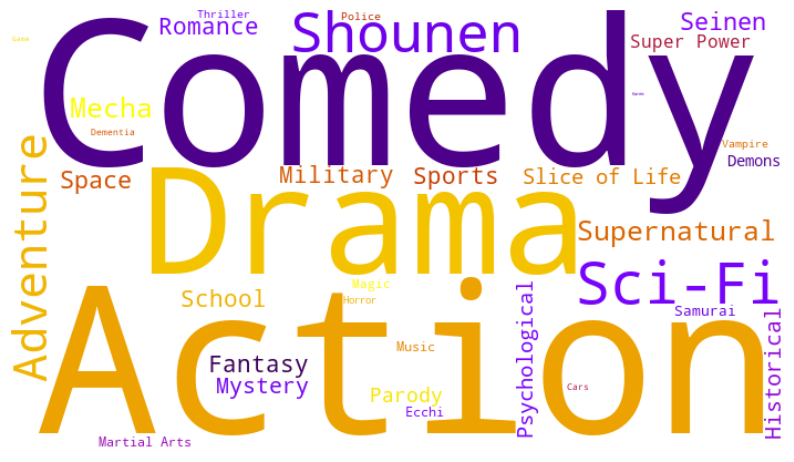

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [144]:
get_user_preferences(11880, rating_df, df,plot=True)

In [145]:
find_similar_users(15019, user_weights, user_encoding, user_decoding)

,similar_users,similarity
9,8075,0.307520
8,7386,0.298347
7,8447,0.292979
6,15684,0.269776
5,4277,0.265191
4,12625,0.263974
3,894,0.262444
2,3164,0.259336
1,11090,0.251404
0,1063,0.251294


In [146]:
def get_user_recomendations(similar_users, user_preferences, df, synopsis_df, rating_df, n=10):
    recommndations = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        pref_list = pref_list[pref_list.eng_version.isin(user_preferences.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
    
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)

                recommndations.append({
                    "n" : n_user_pref,
                    "anime_name": anime_name,
                    "Genre" : genre,
                    "Synopsis" : synopsis
                })
    
    return pd.DataFrame(recommndations).head(n)

In [147]:
similar_users = find_similar_users(11880, user_weights, user_encoding, user_decoding)

In [148]:
user_pref = get_user_preferences(11880, rating_df, df)

In [149]:
get_user_recomendations(similar_users, user_pref, df, synopsis_df, rating_df)

,n,anime_name,Genre,Synopsis
0,7,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power","Hunter x Hunter is set in a world where Hunters exist to perform all manner of dangerous tasks like capturing criminals and bravely searching for lost treasures in uncharted territories. Twelve-year-old Gon Freecss is determined to become the best Hunter possible in hopes of finding his father, who was a Hunter himself and had long ago abandoned his young son. However, Gon soon realizes the path to achieving his goals is far more challenging than he could have ever imagined. Along the way to becoming an official Hunter, Gon befriends the lively doctor-in-training Leorio, vengeful Kurapika, and rebellious ex-assassin Killua. To attain their own goals and desires, together the four of them take the Hunter Exam, notorious for its low success rate and high probability of death. Throughout their journey, Gon and his friends embark on an adventure that puts them through many hardships and struggles. They will meet a plethora of monsters, creatures, and characters—all while learning what being a Hunter truly means."
1,7,One Punch Man,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural","The seemingly ordinary and unimpressive Saitama has a rather unique hobby: being a hero. In order to pursue his childhood dream, he trained relentlessly for three years—and lost all of his hair in the process. Now, Saitama is incredibly powerful, so much so that no enemy is able to defeat him in battle. In fact, all it takes to defeat evildoers with just one punch has led to an unexpected problem—he is no longer able to enjoy the thrill of battling and has become quite bored. This all changes with the arrival of Genos, a 19-year-old cyborg, who wishes to be Saitama's disciple after seeing what he is capable of. Genos proposes that the two join the Hero Association in order to become certified heroes that will be recognized for their positive contributions to society, and Saitama, shocked that no one knows who he is, quickly agrees. And thus begins the story of One Punch Man , an action-comedy that follows an eccentric individual who longs to fight strong enemies that can hopefully give him the excitement he once felt and just maybe, he'll become popular in the process."
2,7,Bakuman.,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
3,6,Eureka Seven,"Adventure, Drama, Mecha, Romance, Sci-Fi","In the backwater town of Bellforest lives a 14-year-old boy named Renton Thurston. He desires to leave his home behind and join the mercenary group known as Gekkostate, hoping to find some adventure to brighten up his mundane life. However, stuck between his grandfather's insistence to become a mechanic like him and the pressure of his deceased father's legacy, the only excitement Renton finds is in his pastime of riding the Trapar wave particles that are dispersed throughout the air, an activity akin to surfing. Everything changes when an unknown object crashes through Renton's garage, discovered to be a Light Finding Operation—a robot capable of riding the Trapar waves—specifically known as the Nirvash typeZERO. Its pilot is a young girl named Eureka, a member of the Gekkostate, who requests a tune-up for the Nirvash. Their meeting sparks the beginning of Renton's involvement with the G

#### Hybrid recommendation system

In [150]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user_encoding,user_decoding)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recomendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime_encoding, anime_decoding, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

In [151]:
hybrid_recommendation(11880)

['Hunter x Hunter', 'One Punch Man', 'Bakuman.', 'Eureka Seven', 'GATE', 'Bakemonogatari', 'Puella Magi Madoka Magica', 'Durarara!!', 'The Melancholy of Haruhi Suzumiya', 'Summer Wars']


['Hunter x Hunter',
 'One Punch Man',
 'Bakuman.',
 'Eureka Seven',
 'GATE',
 'Bakemonogatari',
 'Puella Magi Madoka Magica',
 'Durarara!!',
 'The Melancholy of Haruhi Suzumiya',
 'Summer Wars']

In [ ]:
def anime_recommendation(anime_name, n=10):
    similar_animes_df = find_similar_animes(
        anime_name,
        anime_weights,
        anime_encoding,
        anime_decoding,
        df,
        synopsis_df,
        n=n
    )

    if similar_animes_df is not None and not similar_animes_df.empty:
        return similar_animes_df["name"].tolist()
    else:
        print(f"No similar anime found for {anime_name}")
        return

In [157]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime_encoding,
    anime_decoding,
    df,
    synopsis_df,
    n=10
)

,name,similarity,genre,synopsis
9,Maji,0.331600,"Drama, Shounen","aji is a young hood in the Nagisa criminal organization whose name is synonymous with loyalty and truth. While driving away thugs, he meets and falls for local high school girl, Kumiko; however, complications ensue when he and his group run into the rival Kikuchi gang looking for trouble. Based on the first four volumes of the gang chivalry manga by Ayumi Tachihara. (Source: ANN)"
8,Mind Game,0.328415,"Adventure, Comedy, Dementia, Psychological, Romance","fter seeing her jump onto a subway at the last second and getting her ankle crushed between the doors, Nishi reconnects with his high school sweetheart, Myon. Nishi is still very much in love with Myon, but is shocked to learn that she is engaged to another man. Nishi agrees to meet Myon's fiancé at her family's Yakitori restaurant, but members of the Yakuza storm the joint and murder Nishi when he tries to stop them from raping Myon. Nishi, now dead, wakes up and meets a constantly shapeshifting god, who mocks him for dying. The god tells Nishi to walk into a portal and disappear from existence, which Nishi rejects, choosing instead to sprint past the god and reanimate. With a new outlook on life and knowledge of how the Yakuza are going to attack him, Nishi kills one of the Yakuza with his own gun, fleeing in a stolen car with Myon and her sister. Acclaimed director Masaaki Yuasa's debut film, Mind Game 's constantly shifting visuals tell a story about living one's life without regrets that is unlike any other."
7,1000-nen Joou: Queen Millennia,0.324893,"Adventure, Fantasy, Drama, Sci-Fi","D 1999, the Earth was in a critical situation; a planet Lar Metal was approaching to the Earth. Meanwhile, Yukino Yayoi was heard about Lar Metal from Dr. Amamori of Tokyo Observatory. She was a junior high school teacher, but she also worked for Dr. Amamori who appreciated her astronomical knowledge. Actually Yukino Yayoi was Queen Millennia who had come from Lar Metal 1000 years before, and she had been watching human beings since then. Soon, numerous meteors fell on the Earth, and people were in panic. In this catastrophe, Hajime, who was a student of Yayoi, came to help Yayoi. Yayoi invited him into a big cave under the ground. (Source: AnimeNfo)"
6,Tamayura: More Aggressive,0.306620,"Comedy, Drama, Slice of Life",The second season of Tamayura: Hitotose. It's the beginning of a new school year for Fuu and friends. With a new year comes new challenges as Fuu tries to open a photography club at her school. (Source: ANN)
5,The Sparrow with the Slit Tongue,0.301756,Drama,No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
4,Isobe Isobee Monogatari: Ukiyo wa Tsurai yo,0.292771,"Comedy, Historical","In this ukiyoe-style flash anime, Isobe Isobee is a lazy, slacker samurai with big dreams. He lives with his mother, who thinks highly of him. He lays around the house, sneakily looks at Edo-period pornography without his mother noticing, naps at school, but he plans to become a respectable samurai one day! (Source: MangaHelpers, edited)"
3,Hunter x Hunter: Greed Island,0.292062,"Action, Adventure, Super Power, Fantasy, Shounen","fter the battle with the Spiders, the search for Ging continues as Gon and Killua decided to once again attempt to purchase the rare game ""Greed Island"". However, Gon came up with a better plan, which was to volunteer to complete the game for the billionaire who owned it. But some training must be done, as Gon and Killua's abilities are still at a developing stage and ""Greed Island"" is no simple game for anyone to play with. It is the infamous game that could easily lead to one's death. Based on the manga by Togashi Yoshihiro."
2,Kankara Sanshin,0.285286,"Drama, Historical","film about the Battle of Okinawa during the last days of World War II. During the World War II island hopping campaign there was a fierce battle on Okinawa that devastated th

In [158]:
anime_recommendation("Steins;Gate", n=10)

['Maji',
 'Mind Game',
 '1000-nen Joou: Queen Millennia',
 'Tamayura: More Aggressive',
 'The Sparrow with the Slit Tongue',
 'Isobe Isobee Monogatari: Ukiyo wa Tsurai yo',
 'Hunter x Hunter: Greed Island',
 'Kankara Sanshin',
 'SKET Dance',
 'Yume Miru Jump']